# Unlabeled EDA & Labeling

## Imports

In [805]:
import pandas as pd
import numpy as np
import re

from snorkel.labeling import labeling_function
from snorkel.labeling import PandasLFApplier
from snorkel.labeling import LFAnalysis
from snorkel.analysis import get_label_buckets
from snorkel.labeling import LabelingFunction
from snorkel.preprocess import preprocessor
from snorkel.labeling.model import MajorityLabelVoter
from snorkel.labeling.model import LabelModel

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import preprocessor as p

# For sentiment analysis
from textblob import TextBlob
import emot

from better_profanity import profanity

**Pre-defined functions**

In [585]:
# Function to print full text of indicated dataset
def print_text(text_df):
    for i in text_df.index:
        print(i)
        print(text_df['text'][i])
        print('-----')

In [397]:
# build function to look up keywords
def keyword_lookup(x, keywords, label):
    if any(word in x.text.lower() for word in keywords):
        return label
    return ABSTAIN

def make_keyword_lf(keywords, label=VAX):
    return LabelingFunction(
        name=f"keyword_{keywords[0]}",
        f=keyword_lookup,
        resources=dict(keywords=keywords, label=label),
    )

In [208]:
# Function to return LFAnalysis on validation dataset
def analyze(lfs, return_df=False):
    applier = PandasLFApplier(lfs=lfs)
    L_train = applier.apply(df=val)
    
    display(LFAnalysis(L=L_train, lfs=lfs).lf_summary())
    
    return L_train

In [490]:
# text processing function
def text_process(df, text):
    # Removing hashtags, URLs, mentions, reserved words, emojis, smileys
    df['clean_txt'] = df[text].apply(lambda x: p.clean(x))
    
    # Remove digits
    df['clean_txt'] = df['clean_txt'].str.replace('\d+', '', regex=True)
    
    # remove punctuations
    df['clean_txt'] = df['clean_txt'].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))
    
    # lower case
    df['clean_txt'] = df['clean_txt'].str.lower()

___

## Data Loading

I will be using 2 different datasets for this project. One dataset is labeled based on hashtags that relate to either anti-vaccine or pro-vaccine tweets. The other unlabeled dataset are randomly collected about covid vaccine regardless of the presence of hashtags--only way to tell whether the tweet would be anti or pro vax is by going through each posts and processing the information. This portion of the notebook will be focused on labeling the unlabeled (no hashtag labeling) dataset using a tool called Snorkel. 

In [70]:
# Load unlabeled dataset
tweets = pd.read_csv('../data/twitter_scrape2.csv')
tweets.head()

,datetime,tweet_id,username,text,likes,retweet
0,2021-01-20 23:59:58+00:00,1.352043e+18,AliceMaySays,@acevenvevo @ADM_Briggs @Anthony37662002 @Vibe...,2.0,0.0
1,2021-01-20 23:59:52+00:00,1.352043e+18,Elijah4Senate,Please read this important thread from my offi...,7.0,4.0
2,2021-01-20 23:59:42+00:00,1.352043e+18,yvngdaggadickk,Just saw two homeless people giving themselves...,6.0,0.0
3,2021-01-20 23:59:40+00:00,1.352043e+18,patinindy,Those who refuse to get the COVID-19 vaccine c...,0.0,0.0
4,2021-01-20 23:59:38+00:00,1.352043e+18,KION546,Santa Cruz County says the goal is to distribu...,3.0,0.0


In [71]:
tweets.shape

(111959, 6)

In [72]:
# drop rows with null text values
tweets['text'].isnull().sum()

2

In [73]:
tweets.dropna(subset='text', inplace=True)

In [74]:
tweets.shape

(111957, 6)

I will split the data into 4 sets for the purpose of labeling and running the model on; developement set to build the labeling function, validation set to modify the labeling function and hyperparameter tuning, training set to train the model on, and the test set to validate the model. 

The labeling process alone will need the developement set and validation set. I will set aside 0.1 of dataset for building and modifying the labeling function; then, 300 rows will additionally be split for developement set. 

In [75]:
tweets_label = tweets.sample(frac=0.1, random_state=42)
tweets_label

,datetime,tweet_id,username,text,likes,retweet
33809,2021-07-07 23:56:19+00:00,1.412923e+18,freshniq,@JacksonPokorney @TimRunsHisMouth The same way...,0.0,0.0
3113,2021-02-04 23:56:39+00:00,1.357478e+18,TALK1370,UPDATE: J&amp;J asks US regulators to OK its o...,0.0,0.0
58987,2021-11-09 23:53:44+00:00,1.458221e+18,caitlin_priest,Grateful and relieved beyond measure to get ou...,22.0,3.0
57363,2021-11-01 23:54:31+00:00,1.455322e+18,ThePulse_one,"More than 4,000 health-care workers in British...",3.0,4.0
84237,2022-03-15 23:55:10+00:00,1.503883e+18,wrwilder,@rfsquared Why are we outsourcing our vaccine ...,14.0,1.0
...,...,...,...,...,...,...
92820,2022-04-26 23:40:28+00:00,1.519099e+18,RealMalaton,The goal of the CCP is to destroy the West and...,0.0,0.0
26112,2021-05-29 23:38:34+00:00,1.398786e+18,suemazzy1,Did Tehan just say Morrison is going to UK?! Q...,10.0,5.0
90230,2022-04-13 23:24:39+00:00,1.514384e+18,postlogix,Post-covid vaccine syndrome is part of the new...,0.0,0.0
23803,2021-05-18 23:52:28+00:00,1.394803e+18,SahayNirmal,When you can be COVID positive even after succ...,1.0,1.0


In [76]:
# remove the labeling subset from the dataset that will be used for modelining 
tweets_model = tweets.drop(index=tweets_label.index)
tweets_model.shape

(100761, 6)

In [77]:
# sample 300 rows from tweets_label for developement set 
dev = tweets_label.sample(300, random_state=42)
dev.shape

(300, 6)

In [78]:
# rest of the tweets_label is for label validation
val = tweets_label.drop(index=dev.index)
val.shape

(10896, 6)

In [79]:
# reset indeces for the 3 sets
tweets_model = tweets_model.reset_index(drop=True)
dev = dev.reset_index(drop=True)
val = val.reset_index(drop=True)

I will export the development set for manual labeling

In [80]:
dev.to_excel('../data/tweets_dev.xlsx', index=False)

I will also set aside a subset from hashtag labeled data, for an extra measure of snorkel label validation. 

In [647]:
# load labeled data 
tweets_labeled = pd.read_csv('../data/tweets_labeled_dev.csv')

In [649]:
tweets_labeled.head()

,datetime,text,p_text,hashtag,get_vaccine
0,2022-04-06 00:10:12+00:00,@CoquiTalksTrash I will not do it.\nVaccines do not stop spread or transmission.\nVaccines have ...,i will not do it vaccines do not stop spread or transmission vaccines have side effects that can...,[],0
1,2021-08-31 20:04:29+00:00,"CALEB WALLACE, ANTI-MASK ORGANIZER AND CO-FOUNDER OF THE SAN ANGELO FREEDOM DEFENDERS, DIES OF C...",caleb wallace anti mask organizer and co founder of the san angelo freedom defenders dies of c...,['IDoNotConsent'],0
2,2020-11-02 13:38:24+00:00,@the_hindu 🗣️ Sure! just like Sister Nirmala promised free Covid #WuhanVirus vaccine for free 🤣 ...,sure just like sister nirmala promised free covid vaccine for free to know more about biden watch,[],0
3,2022-03-24 09:06:10+00:00,Nearly 3.24 billion #COVID19 #vaccine doses had been administered on the Chinese mainland as of ...,nearly billion doses had been administered on the chinese mainland as of wednesday the national...,[],1
4,2021-10-01 05:48:30+00:00,Kim Iversen: Norway DROPS All Restrictions And Chooses To LIVE With Covid https://t.co/O07XfuB4b...,kim iversen norway drops all restrictions and chooses to live with covid via,['novaccine'],0


In [650]:
tweets_labeled.shape

(1000, 5)

In [743]:
print_text(tweets_labeled[tweets_labeled['get_vaccine']==0].sample(20))

619
Dear #antivaxx #antivaxxers #AntiVaxxer #AntiVaccine #antimandate #antimask #COVIDIOT 

5m people have died from Covid, every day we have a 9/11 number of deaths in America.
9/11 EVERY DAY!!!!

Please
#GetVaccinated #GetVaccinatedAndBoosted 💉💉💉
#WearAMask 😷
#COVID19 ☠️☠️ https://t.co/MGZONq7JXZ
-----
973
Covidvaccinw will get ruined by all the ignorant and stupid people who refuses to take them. And because of those people we will never Ever flatten any curve at all. You are selfish and a danger to society. #Covid_19 #vaccine #AntiVaccine
-----
878
I have been accosted and ridiculed for wearing a mask. I understand people have conflicting opinions on the COVID pandemic, but I am not hurting you by wearing a mask. I am protecting myself and my family! #WearAMask #MyBodyMyChoice
-----
311
Covid-19 = The Posthuman System https://t.co/TJjTsix7MZ #Plandemic #PSYOP #NWO #ExposeBillGates #ArrestBillGates #Depopulation #Sterilization #Genocide #Eugenics #NoVax #Illuminati #Agenda2030 #Defu

---

**Developement set manual labeling**

import manually labeled dataset

In [87]:
dev_label = pd.read_excel('../data/tweets_dev_labeled.xlsx')
dev_label.head()

,datetime,tweet_id,username,text,get_vaccinated,likes,retweet
0,2022-07-17 23:50:55+00:00,1.548818e+18,Road_Closed1984,"India's COVID vaccinations hit 2 billion, but ...",0.0,0,0
1,2022-01-01 23:45:15+00:00,1.477426e+18,DeadInside2525,No more vaccines!!! No more bullshit Covid mir...,0.0,2,0
2,2021-11-04 23:57:51+00:00,1.456410e+18,afr52,@VisserMB @POTUS It's still going strong. 41.9...,1.0,0,0
3,2021-11-22 23:46:29+00:00,1.462931e+18,BaksEarl7,HOW MUCH WILL COVID-19 VACCINES COST?\n\nLOOK:...,NaN,0,0
4,2021-04-18 23:54:20+00:00,1.383932e+18,Say_Non_Now,@MarkCanadaEh @AnitaOakville @vankayak @MarkGe...,0.0,0,0


tweets that seemed fairly neutral were left as it is and is marked as NaN value.

In [90]:
dev_label['get_vaccinated'].isnull().sum()

82

In [423]:
dev_label[dev_label['get_vaccinated'] == 1].shape[0]

140

In [425]:
dev_label[dev_label['get_vaccinated'] == 0].shape[0]

78

In [586]:
print_text(dev_label[dev_label['get_vaccinated']==0])

0
India's COVID vaccinations hit 2 billion, but new cases at four-month high. Vaccines do not work and are dangerous https://t.co/8EiKowN8x5
-----
1
No more vaccines!!! No more bullshit Covid miracle pills!!!! ENOUGH!!! https://t.co/v9NhSGONvp
-----
4
@MarkCanadaEh @AnitaOakville @vankayak @MarkGerretsen @TheLeadCNN Don't know the law in Canada but in the US:

The Moderna &amp; Pfizer Covid jabs are legally NOT Vaccines!!!

https://t.co/3RkBnh9jcG
-----
6
@jman37297 @jimmy_dore I got Covid in between my 1st and 2nd dose.  Suffered from
Myocarditis after the 2nd shot.  Will never get boosted.   I have natural and vaccine immunity.  

Getting vaccinated DOES NOT EQUAL not getting/spreading Covid.  

I got Covid from my fully vaccinated mother.
-----
18
@HarmonySearcher @hANdsOmeseaN02 No but you can’t trust doctors after Covid. Good thing the Army gave us smallpox vaccines cause I wouldn’t take anything they offered now for it!
-----
22
Characteristics and risk of #COVID19 -related death

out of 300 posts, 82 have null values, which means I could not figure out myself whether to label the data with 'will get vaccinated' vs 'will not get vaccinated'. With these measures, I would aim for about 2/3 of the whole dataset to get labeled with some value. 

## EDA

* brainstorm labeling function ideas

random validation data subset for generating ideas

In [203]:
print_text(val[['text']].sample(10, random_state=42))

3316
@Clarja_wewon She should talk to her doctor. I have over 300 undiagnosed symptoms, mostly caused from untreated autoimmune issues. For me, I was more afraid of getting covid than the few side affects from the vaccine. Point this out to your friend. It's more dangerous to not be vaccinated.
-----
1710
@grave_acid @WordStitcher @Captaincoby00 Unfortunately, many people do not get the flu shot so more people die from the flu each year than would if everyone who can get it would get it.

Ironically, a new universal flu vaccine was set to be tested in 2020 but the COVID-19 pandemic has delayed the testing. 2/
-----
8188
Getting the vaccine prevents you from getting seriously sick with #COVID19. Families looking to make vaccination appointments can visit https://t.co/XgnlzVHmcm, call the COVID-19 Hotline at (833) 422-4255, or talk to your family’s pediatrician or healthcare provider. https://t.co/pIy3Amid3m
-----
3842
I Tried All Three COVID-19 Vaccines At Once, Here Are My Reviews and 

Following are some keywords to look for in the tweets off of the head

In [409]:
keywords = ['prevent', 
            'experiment', 
            'force', 
            'mandate', 
            'kill', 
            'save', 
            'jab', 
            'safe',
            'dangerous',
            'hiv',
            'myocarditis',
            'clot',
            'autism',
            'children',
            'death',
            'die'
            'transmission',
            'spread']

In [249]:
# Look through the validation dataframe to see what proportion of the dataset contains following keywords
for word in keywords:
    print(word, val[val['text'].str.lower().str.contains(word)].shape[0])

prevent 311
experiment 112
force 150
mandate 536
kill 208
save 144
jab 196
safe 390
dangerous 83
hiv 44
myocarditis 70
clot 98
autism 9
children 313
death 582
transmission 114
spread 389


In [233]:
val.shape[0]

10896

Just by referring to the manually brainstormed keywords, the labeling function will not be able to label significant proportion of the tweets; I will take more systematic/technical approach by generating a wordcloud.

In [491]:
text_process(val, 'text')

In [492]:
# create a list of the texts
text = val['clean'].tolist()

# join the texts into one string
text = ' '.join(text)

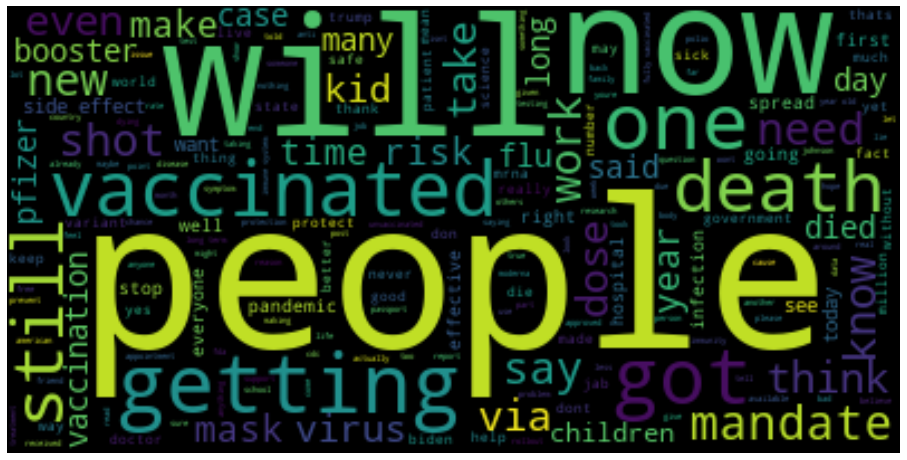

In [347]:
# create wordcloud object
stopwords = list(STOPWORDS) + ['covid',
                               'vaccine',
                               'vaccines',
                               'vax', 
                               'amp']

wordcloud = WordCloud(stopwords = stopwords,
                      collocations = True,
                      min_word_length = 3,
                      collocation_threshold = 10
                     ).generate(text)

# plot the wordcloud object
plt.figure(figsize=(16, 9))
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()

Add to keyword list for investigation

In [410]:
keywords = keywords + ['will',
                       'now',
                       'vaccinated',
                       'people',
                       'risk',
                       'need',
                       'protect'
                      ]

In [349]:
for word in keywords:
    print(word, val[val['text'].str.lower().str.contains(word)].shape[0])

prevent 311
experiment 112
force 150
mandate 536
kill 208
save 144
jab 196
safe 390
dangerous 83
hiv 44
myocarditis 70
clot 98
autism 9
children 313
death 582
transmission 114
spread 389
will 993
now 1369
vaccinated 923
people 1470
risk 426
need 582
protect 417


In [427]:
print_text(val[val['text'].str.lower().str.contains('will')].sample(20, random_state=42))

10053
@Martiecat1 @annconwaytwitty @GeoffDOCJones @SpiroAgnewGhost Vaccines have been proven effective.  And they will prevent Covid so that treatment isn’t even necessary.
-----
5671
@madmomnotodrugs I am sure that is NOT what the doctor said! I am grateful to #Pfizer.  With 4 booster shots I won't be lying in a hospital if I come in contact with Covid.
Research of a new vaccine takes time. They did their best and will keep doing better.
-----
6085
Am so sick of those bitching the loudest about things going back to normal also being the ones who will do ABSOLUTELY NOTHING to help get us there. Let's get to herd immunity. Either get the vaccine, or get covid. You decide, but you have to get a shot filled with one of them.
-----
7026
#GetVaccinated this weekend! Sites will be open across the island. 

Head to your nearest location to receive your 1st, 2nd or booster dose of a COVID-19 vaccine.

Listed here are the sites for Saturday, March 12. 

#VaccinateJa 1/3

@christufton @julietcut

---

In [103]:
# Define labels 
ABSTAIN = -1
NO_VAX = 0
VAX = 1

### label functions by keywords

Positives

In [685]:
kw_save = make_keyword_lf(keywords=['save'])
kw_prevent = make_keyword_lf(keywords=['prevent'])

In [687]:
# using regex, more extensive keyword lookups
@labeling_function()
def regex_booster(x):
    return VAX if re.search(r"boost(er|ed)?", x.text.lower(), flags=re.I) else ABSTAIN

@labeling_function()
def regex_save_lives(x):
    return VAX if re.search(r"(saves?).*(lives?)", x.text.lower(), flags=re.I) else ABSTAIN

In [688]:
lfs_yes = [kw_save, kw_prevent, regex_booster, regex_save_lives]

In [689]:
L_train=analyze(lfs_yes, True)

100%|██████████████████████████████████| 10896/10896 [00:00<00:00, 27221.01it/s]


,j,Polarity,Coverage,Overlaps,Conflicts
keyword_save,0,[1],0.013216,0.007159,0.0
keyword_prevent,1,[1],0.028543,0.001560,0.0
regex_booster,2,[1],0.044604,0.001744,0.0
regex_save_lives,3,[1],0.006700,0.006700,0.0


negatives

In [764]:
# don't need: (?i)(do|did)(n'?t|( ?not))?.*need
# don't work: (?i)(do|did)(n'?t|( ?not))?.*work

@labeling_function()
def kw_diseases(x):
    myo = re.search(r"myo?card(itis)?", x.text.lower(), flags=re.I)
    others = re.search(r"vasculitis|clot|hiv", x.text.lower(), flags=re.I)
    heart = re.search(r"heart.*(issues?|disease)", x.text.lower(), flags=re.I)
    return NO_VAX if myo or others or heart else ABSTAIN

"""
kw_bad_reactions = make_keyword_lf(keywords=["stroke",
                                             "trigger reaction", #(?i)trigg?er.*reactions?
                                             "bad reaction", #(?i)bad.*reactions?
                                             "harmful effect", 
                                             "adverse"], label=NO_VAX)
"""

@labeling_function()
def kw_bad_rxns(x):
    trigger = re.search(r"trigg?er.*reactions?", x.text.lower(), flags=re.I)
    others = re.search(r"stroke|harmful|adverse", x.text.lower(), flags=re.I)
    rxn = re.search(r"bad.*reactions?", x.text.lower(), flags=re.I)
    side = re.search(r"side effects?", x.text.lower(), flags=re.I)
    return NO_VAX if trigger or others or rxn else ABSTAIN


"""kw_not_need = make_keyword_lf(keywords=["not need", 
                                        "no need",
                                        "don't need",
                                        "dont need",
                                        "do not need"], label=NO_VAX)"""

@labeling_function()
def kw_not_need(x):
    no_need = re.search(r"(do|did)(n'?t|( ?not))?.*need", x.text.lower(), flags=re.I)
    return NO_VAX if no_need else ABSTAIN

# kw_jab = make_keyword_lf(keywords=["jab"], label=NO_VAX)

@labeling_function()
def kw_jab(x):
    return NO_VAX if "jab" in x.text.lower() else ABSTAIN

"""kw_not_work = make_keyword_lf(keywords=["don't work", # don't work: (?i)(do(es)?|did)(n'?t|( ?not))?.*work
                                        "dont work",
                                        "do not work",
                                        "doesn't work",
                                        "doesnt work",
                                        "does not work"
                                       ], label=NO_VAX)"""


@labeling_function()
def kw_not_work(x):
    no_work = re.search(r"(do(es)?|did)(n'?t|( ?not))?.*work", x.text.lower(), flags=re.I)
    return NO_VAX if no_work else ABSTAIN


"""kw_gov_control = make_keyword_lf(keywords=["gov control",
                                           "government control", # (?i)gov(ernment)?
                                           "force" #(?i)force
                                          ], label=NO_VAX)"""

@labeling_function()
def kw_gov(x):
    gov = re.search(r"gov(ernment)?", x.text.lower(), flags=re.I)
    force = re.search(r"force", x.text.lower(), flags=re.I)
    return NO_VAX if gov or force else ABSTAIN

# kw_ineffective = make_keyword_lf(keywords=["ineffective"], label=NO_VAX) # (?i)(not.*effective)|ineffective

@labeling_function()
def kw_ineffective(x):
    ineff = re.search(r"(not.*effective)|ineffective", x.text.lower(), flags=re.I)
    return NO_VAX if ineff else ABSTAIN

"""kw_cant_trust = make_keyword_lf(keywords=["can't trust", # can't trust: (?i)(can?|could)(n'?t|( ?not))?.*trust
                                          "cant trust", # (?i)do(n'?t|( ?not))?.*trust
                                          "can not trust", # (?i)(will|wo)(n'?t|( ?not))?.*trust
                                          "will not trust",
                                          "won't trust",
                                          "wont trust"
                                         ], label=NO_VAX)"""

@labeling_function()
def kw_not_trust(x):
    cant = re.search(r"(can?|could)(n'?t|( ?not))?.*trust", x.text.lower(), flags=re.I)
    wont = re.search(r"do(n'?t|( ?not))?.*trust", x.text.lower(), flags=re.I)
    dont = re.search(r"(will|wo)(n'?t|( ?not))?.*trust", x.text.lower(), flags=re.I)
    return NO_VAX if cant or wont or dont else ABSTAIN


# kw_big_pharma = make_keyword_lf(keywords=["big pharma"], label=NO_VAX)

@labeling_function()
def big_pharma(x):
    return NO_VAX if "big pharm" in x.text.lower() else ABSTAIN

"""kw_not_prevent = make_keyword_lf(keywords=["not prevent", # (?i)(do(es)?|did)(n'?t|( ?not))?.*prevent
                                           "doesn't prevent",
                                           "don't prevent",
                                           "won't prevent",
                                           "dont prevent",
                                           "doesnt prevent",
                                           "wont prevent"
                                          ], label=NO_VAX)"""


@labeling_function()
def kw_not_prevent(x):
    cant = re.search(r"(can?|could)(n'?t|( ?not))?.*prevent", x.text.lower(), flags=re.I)
    wont = re.search(r"do(n'?t|( ?not))?.*prevent", x.text.lower(), flags=re.I)
    dont = re.search(r"(will|wo)(n'?t|( ?not))?.*prevent", x.text.lower(), flags=re.I)
    return NO_VAX if cant or wont or dont else ABSTAIN

# kw_lie = make_keyword_lf(keywords=['lie'], label=NO_VAX) (?i)li(ed|es|ar|er)

@labeling_function()
def kw_lie(x):
    return NO_VAX if re.search(r" li(ed|es|ar|er)", x.text.lower(), flags=re.I) else ABSTAIN


# kw_scam = make_keyword_lf(keywords=['scam'], label=NO_VAX)

@labeling_function()
def kw_scam(x):
    return NO_VAX if "scam" in x.text.lower() else ABSTAIN

In [765]:
lfs_no = [kw_diseases, 
          kw_bad_rxns,
          kw_not_need,
          kw_jab,
          kw_not_work,
          kw_gov,
          kw_ineffective,
          kw_not_trust,
          kw_big_pharma,
          kw_not_prevent,
          kw_lie,
          kw_scam]

In [766]:
L_train = analyze(lfs_no)

100%|███████████████████████████████████| 10896/10896 [00:02<00:00, 5399.42it/s]


,j,Polarity,Coverage,Overlaps,Conflicts
kw_diseases,0,[0],0.020833,0.003029,0.0
kw_bad_rxns,1,[0],0.012941,0.002570,0.0
kw_not_need,2,[0],0.018998,0.004130,0.0
kw_jab,3,[0],0.017988,0.003579,0.0
kw_not_work,4,[0],0.027900,0.006975,0.0
kw_gov,5,[0],0.063601,0.009453,0.0
kw_ineffective,6,[0],0.007617,0.002478,0.0
kw_not_trust,7,[0],0.006608,0.002019,0.0
keyword_big pharma,8,[0],0.003120,0.001285,0.0
kw_not_prevent,9,[0],0.019732,0.003671,0.0


In [696]:
lfs_keywords = lfs_yes + lfs_no

In [697]:
L_train = analyze(lfs_keywords)

100%|███████████████████████████████████| 10896/10896 [00:02<00:00, 4883.65it/s]


,j,Polarity,Coverage,Overlaps,Conflicts
keyword_save,0,[1],0.013216,0.008443,0.002662
keyword_prevent,1,[1],0.028543,0.022118,0.021476
regex_booster,2,[1],0.044604,0.009637,0.008535
regex_save_lives,3,[1],0.006700,0.006700,0.001377
kw_diseases,4,[0],0.020833,0.004038,0.000918
kw_bad_rxns,5,[0],0.012941,0.003120,0.000459
kw_not_need,6,[0],0.018998,0.005598,0.002478
kw_jab,7,[0],0.017988,0.005140,0.001836
kw_not_work,8,[0],0.027900,0.009820,0.003855
kw_gov,9,[0],0.063601,0.013491,0.004314


### Hashtags

In [430]:
val['hashtag'] = val['text'].apply(lambda x: re.findall(r"#(\w+)", x))
val.head()

,datetime,tweet_id,username,text,likes,retweet,clean,hashtag
0,2021-07-07 23:56:19+00:00,1.412923e+18,freshniq,@JacksonPokorney @TimRunsHisMouth The same way anti-vaxxers and vaccine hesitant people die from...,0.0,0.0,the same way anti vaxxers and vaccine hesitant people die from covid,[]
1,2021-02-04 23:56:39+00:00,1.357478e+18,TALK1370,UPDATE: J&amp;J asks US regulators to OK its one-shot COVID-19 vaccine https://t.co/pAICjnC2oi,0.0,0.0,update j amp j asks us regulators to ok its one shot covid vaccine,[]
2,2021-11-09 23:53:44+00:00,1.458221e+18,caitlin_priest,Grateful and relieved beyond measure to get our little dude his #CovidVaccine ❤️ https://t.co/u...,22.0,3.0,grateful and relieved beyond measure to get our little dude his,[CovidVaccine]
3,2021-11-01 23:54:31+00:00,1.455322e+18,ThePulse_one,"More than 4,000 health-care workers in British Columbia, Canada, that have not received at least...",3.0,4.0,more than health care workers in british columbia canada that have not received at least one d...,[VaccineMandate]
4,2022-03-15 23:55:10+00:00,1.503883e+18,wrwilder,@rfsquared Why are we outsourcing our vaccine approval? Israel is not comparable to the US in de...,14.0,1.0,why are we outsourcing our vaccine approval israel is not comparable to the us in demographics ...,[]


In [447]:
hashtags = {}

for i in val.index:
    for item in val['hashtag'][i]:
        if item not in hashtags.keys():
            hashtags[item] = 0
        
        hashtags[item] += 1
        

In [461]:
hashtag_df = pd.DataFrame(hashtags.values(), index=hashtags.keys(), columns=['n_hashtags'])

In [465]:
hashtag_df.sort_values('n_hashtags', ascending=False).head(20)

,n_hashtags
CovidVaccine,315
COVID19,170
vaccine,128
COVID,111
covid,78
Covid,75
vaccines,58
coronavirus,52
covidvaccine,50
Covid_19,46


I will examine some top hashtags

In [469]:
print_text(val[val['text'].str.contains('#CovidVaccine')].sample(10, random_state=42))

6065
Finally got my booster today! (I had my 2nd dose in May so sorta overdue)
Didn’t think I’d get another sticker so that’s fun 😜#CovidVaccine #Boosted https://t.co/fkoM9tFykf
-----
1103
Aged care residents haven’t received 2 doses of #CovidVaccine but @ScottMorrisonMP and @GregHuntMP have. Liberal government cares only about themselves. #auspoI #scottyslockdown #ScoVid #ScottyDoesNothing
-----
5860
I hope to receive a vaccination soon!!  #CovidVaccine https://t.co/nH81x7MP1x
-----
2645
@Reuters And the reason is clear and unambiguous: Today the 7-day average number of people newly infected climbed to 766,793 - over 3/4 million are getting sick EVERY day. It has NEVER been so high, ever. Some countries affected far more than others...
#COVID #COVID19 #CovidVaccine
-----
3026
So happy &amp; grateful! A trip to #Portland Intl Airport for the #CovidVaccine clinic! Joining esteemed #NP friends on frontlines near &amp; far @Rachel_Prusak @bean_dnp @freed_shelby @DrPattyRN... &amp; so many

In [471]:
print_text(val[val['text'].str.contains('#vaccine')].sample(10, random_state=42))

10728
Why stop at 3 @pfizer @pfizer_news ? Let’s keep pumping experimental needles into our body #vaccination #vaccines #Covid #CovidVaccine #help. Might as well get a @Nike or @adidas #vaccine https://t.co/XTu9s9Gb8N
-----
4593
Manitoba, Saskatchewan within days of vaccinating kids from six months - #news #canada #saskatchewan #manitoba #covidsk #covid19 #covid #healthcare #covidvaccine #covidbooster #vaccinemandates #government #saskpoli #skpoli #mbpoli #wpgpoli https://t.co/ql9VUHpzxl
-----
2960
Join us Tomorrow on @Clubhouse inside @LakersNationCH as we host our 2nd Covid Panel! Beyond super proud of our Admin &amp; Mod squad ambition, dedication &amp; hard work! Pre submit any questions in comments or via Dm! Thank you everyone, go Lakers! #LakerNationCH #COVID19 #vaccine https://t.co/CQeNu4VlZX
-----
7775
Need a ride to get your COVID shot? Uber and Lyft are giving free rides.

#twomillionarmskc #covid19 #vaccines #kansascity #kc #comebackkc

https://t.co/gWE6OMDxoj
-----
9551
Ru

With a high precision, posts with #CovidVaccine or anything vaccine related tend to be optimistic about getting vaccinated. On the other hand, #COVID (or related) hashtag by itself has mixed results. Therefore, I will include the hashtags as a labeling measure.

previous EDA on hashtag labeled data, used a set of hashtag that defined pro or anti vax

In [680]:
# Reading and listing no_vac hashtags
file = open("../data/antivax_hashtags.txt", "r")
data = file.read()
antivax_hash = data.split("\n")
file.close()

# Reading and listing yes_vac hashtags
file = open("../data/provax_hashtags.txt", "r")
data = file.read()
provax_hash = data.split("\n")
file.close()

In [783]:
kw_antihash = make_keyword_lf(keywords=antivax_hash, label=NO_VAX)

kw_prohash = make_keyword_lf(keywords=provax_hash, label=VAX)

kw_hash_vaccines = make_keyword_lf(keywords=["#CovidVaccine",
                                             "#vaccine",
                                             "#vaccines",
                                             "#covidvaccine",
                                             "#vaccination",
                                             "#COVIDVaccine",
                                             "#Vaccine",
                                             "#GetVaccinated"], label=VAX)

In [784]:
lfs_hash = [kw_antihash, kw_prohash, kw_hash_vaccines]

In [779]:
L_train = analyze(lfs_hash)

100%|███████████████████████████████████| 10896/10896 [00:03<00:00, 2755.96it/s]


,j,Polarity,Coverage,Overlaps,Conflicts
keyword_abolishbigpharma,0,[0],0.027533,0.018264,0.018264
keyword_CancelCovid,1,[1],0.088106,0.023128,0.016795
keyword_#CovidVaccine,2,[1],0.060940,0.008443,0.002111


### Hyperlinks

In [485]:
print_text(val[val['text'].str.contains('http')].sample(20, random_state=7))

9777
Plus Metro-North working on improving Breakneck Station, fake COVID-19 vaccine cards and more: Hudson Valley Daily Digest. https://t.co/nHCB7VYUEr
-----
2838
@Hbomb08119074 @MHav57783468 @Unko67427980 @carey1canada Yes, because the Covid vaccine doesn't provide sterilized immunity (very few vaccines do) - it slows the spread and reduces severity of infections. 
You getting Covid does not prove the vaccine to be ineffective. 
Anecdotes do not equal data. https://t.co/bsDtE3tH5m
-----
2122
Pharmaceutical Companies, The Government &amp; Health Care Workers are immune from responsibility if the Covid Vaccine harms people. It was rushed to market for political &amp; profit motivations. If they cared about saving lives why not ban smoking &amp; save 400,000 lives a year. https://t.co/Zd6wxoaPAX
-----
8315
Perhaps Texas should secede.

Texas Gov. Greg Abbott bans COVID-19 vaccine mandates by any entity https://t.co/rdQwo17WDk via @YahooNews
-----
3850
"We are seeing kids with COVID-19 in

In [486]:
kw_https = make_keyword_lf(keywords=['http'])

In [652]:
lfs_http = [kw_https]

In [487]:
L_train = analyze(lfs=lfs_http)

100%|██████████████████████████████████| 10896/10896 [00:00<00:00, 74165.84it/s]


,j,Polarity,Coverage,Overlaps,Conflicts
keyword_http,0,[1],0.446219,0.0,0.0


### Sentence Length

Is there any difference between sentence length of "get_vaccinated" and "not_get_vaccinated" populations? Will stick to the meaningful parts of text by preprocessing. 

In [493]:
text_process(dev_label, 'text')

In [494]:
dev_label

,datetime,tweet_id,username,text,get_vaccinated,likes,retweet,clean_txt
0,2022-07-17 23:50:55+00:00,1.548818e+18,Road_Closed1984,"India's COVID vaccinations hit 2 billion, but new cases at four-month high. Vaccines do not work...",0.0,0,0,india s covid vaccinations hit billion but new cases at four month high vaccines do not work a...
1,2022-01-01 23:45:15+00:00,1.477426e+18,DeadInside2525,No more vaccines!!! No more bullshit Covid miracle pills!!!! ENOUGH!!! https://t.co/v9NhSGONvp,0.0,2,0,no more vaccines no more bullshit covid miracle pills enough
2,2021-11-04 23:57:51+00:00,1.456410e+18,afr52,@VisserMB @POTUS It's still going strong. 41.9% of our population are resisting taking the vacci...,1.0,0,0,it s still going strong of our population are resisting taking the vaccine probably be getti...
3,2021-11-22 23:46:29+00:00,1.462931e+18,BaksEarl7,HOW MUCH WILL COVID-19 VACCINES COST?\n\nLOOK: Prices of eyed COVID-19 vaccines for distribution...,NaN,0,0,how much will covid vaccines cost look prices of eyed covid vaccines for distribution in the ...
4,2021-04-18 23:54:20+00:00,1.383932e+18,Say_Non_Now,@MarkCanadaEh @AnitaOakville @vankayak @MarkGerretsen @TheLeadCNN Don't know the law in Canada b...,0.0,0,0,don t know the law in canada but in the us the moderna amp pfizer covid jabs are legally not v...
...,...,...,...,...,...,...,...,...
295,2022-05-22 23:25:16+00:00,1.528517e+18,dmkchf,@WHCOS @POTUS COVID solved itself thru vaccines developed during the Trump administration. Job ...,NaN,0,0,covid solved itself thru vaccines developed during the trump administration job growth has occu...
296,2021-02-14 23:53:59+00:00,1.361101e+18,jessamariepole,"@Codyjayartistry To others reading this:\n\n1) It's 95% effective, not 100% effective.\n2) It pr...",1.0,15,1,to others reading this it s effective not effective it prevented severe disease requiri...
297,2021-05-02 23:40:00+00:00,1.389002e+18,NewstalkZB,#LISTEN Government urged to involve pharmacists in Covid vaccine rollout\n\nhttps://t.co/ex9SYxH...,NaN,1,1,government urged to involve pharmacists in covid vaccine rollout
298,2021-04-19 23:59:40+00:00,1.384296e+18,cunnennedy,"@Philly_OnAir I suggested the city use our mosquito spraying helicopters, fill em with covid vac...",1.0,1,0,i suggested the city use our mosquito spraying helicopters fill em with covid vaccines and that...


In [496]:
dev_label['word_count'] = dev_label['clean_txt'].map(lambda x:len(x.split()))

In [497]:
dev_label.groupby('get_vaccinated')['word_count'].mean()

get_vaccinated
0.0    29.794872
1.0    31.764286
Name: word_count, dtype: float64

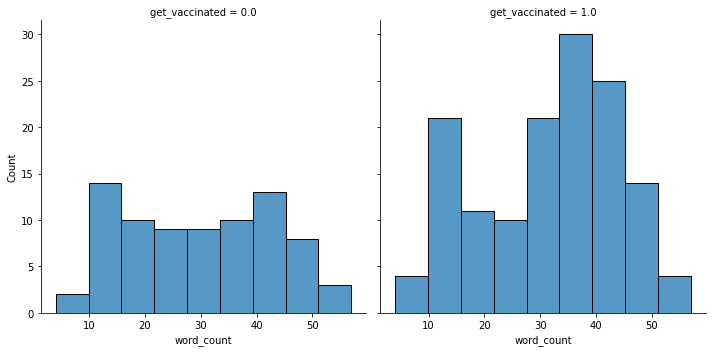

In [500]:
sns.displot(dev_label,
            x = 'word_count',
            col = 'get_vaccinated'
           );

Not too much difference in post length; 

### Sentiment and Subjectivity Scores

Expect that more positive posts are usually willing to get vaccine (being grateful and happy to get vaccines).

Test the subjectivity. Both pro and anti could be equally subjective. 

In [724]:
@preprocessor(memoize=True)
def textblob_sentiment(x):
   
    text = x.text
    if re.search('[\U00010000-\U0010ffff]', x.text, flags=re.UNICODE):
        emo = emot.core.emot() # This will change emoji to text data so that it can be processed in textblob senetiment analyzer
        emot_to_text = emo.emoji(text)

        for i, emoji in enumerate(emot_to_text['value']):
            text.replace(emoji, emot_to_text['mean'][i])
    
    scores = TextBlob(text)
    x.polarity = scores.sentiment.polarity
    x.subjectivity = scores.sentiment.subjectivity
    return x

In [750]:
@labeling_function(pre=[textblob_sentiment])
def textblob_positive(x):
    return VAX if x.polarity > 0.2 else ABSTAIN

@labeling_function(pre=[textblob_sentiment])
def textblob_negative(x):
    return NO_VAX if x.polarity < -0.2 else ABSTAIN

@labeling_function(pre=[textblob_sentiment])
def textblob_subjectivity(x):
    return VAX if x.subjectivity <= 0.2 else ABSTAIN

In [751]:
lfs_sent = [textblob_positive, textblob_negative, textblob_subjectivity]

In [752]:
L_train = analyze(lfs=lfs_sent)

100%|██████████████████████████████████| 10896/10896 [00:00<00:00, 29871.68it/s]


,j,Polarity,Coverage,Overlaps,Conflicts
textblob_positive,0,[1],0.241373,0.00156,0.00000
textblob_negative,1,[0],0.086454,0.00156,0.00156
textblob_subjectivity,2,[1],0.282030,0.00312,0.00156


In [519]:
print_text(val.iloc[L_train[:, 0] == VAX].sample(10, random_state=42))

7859
All your County services in one location at the Block Party. Cat &amp; kitten adoptions, COVID-19 vaccines, voter registration, library card sign-ups and more plus live music, scavenger hunt and raffle prizes.
https://t.co/x7CkgpTIod https://t.co/2rgMXVPHO3
-----
5671
@madmomnotodrugs I am sure that is NOT what the doctor said! I am grateful to #Pfizer.  With 4 booster shots I won't be lying in a hospital if I come in contact with Covid.
Research of a new vaccine takes time. They did their best and will keep doing better.
-----
8241
golden by harry styles was playing while I got my first covid vaccine dose today so I think that’s a good sign
-----
3677
@Delvingay @ToddJohnson1965 @newsmax Covid is easily treatable with a vaccine.

Cancer doesn’t spread from person to person like Covid does.
-----
3581
@LaughlandMorgan @Kathmarval @FletchRexxx @groin_hammer @JCDeardeuff @ross_country @JuliaHadley15 @ryNOdis @Chris_F_Carson @IamIron62 @Rose_Ham10 @wjack76995 @paullombardi2 @JoeCoyle

In [527]:
print_text(val.iloc[L_train[:, 1] == NO_VAX].sample(10, random_state=42))

8348
Took a covid test. I don't have covid I'm just suffering from side effects from the vaccine. I'm in fucking agony.
-----
1155
Cactus flowers 🌵🌸
No walk today because I am sick
Not with Covid, thank goodness 
Sinus infection 🤧 
Vaccine tomorrow 💉 https://t.co/FhMBqQiQb2
-----
9339
@JustinTrudeau We care about us not getting killed by covid so take the vaccine, now a woman can murder a child. The worst mistake is to let government making decision for us
-----
6072
Tucker Carlson Commits His Worst Act of Vaccine Hypocrisy Yet. TUCKER LIES ALL THE TIME ABOUT COVID, SO WHY IS JOE ROGAN GET SLAMMED AND TUCKER NOT. #SmartNews  https://t.co/7QwDzwwBtq
-----
4659
@RSkogg @dvillella @RexChapman @stuartpstevens @TheRickWilson Nobody should be dying from a vaccine, stupid. We're talking covid, NOW.
-----
9239
Another GOP anti-science, anti-vax idiot ⁦⁦@RepThomasMassie⁩ said he  won't get vaccine until it 'improves' immunity after COVID infection 😲😡

This is the dude who is a co-sponsor of QAn

In [484]:
print_text(val[val['text'].str.contains('!')].sample(10, random_state=42))

5406
Come see us tomorrow at Children's Day in the Plaza! 🎉 

Saturday, April 2
10 AM - 3 PM
SLO Mission Plaza
989 Chorro St
San Luis Obispo, CA 93401

We'll be available to answer questions and offering Flu and COVID-19 vaccines for ages 5+. https://t.co/dcB6HZVWHP
-----
6497
@heather54915393 @jesus_jimz Heather don’t bother telling idiots this, somehow Covid just disappeared and will never get you because the vaccine is bulletproof! I’m glad you do as a med dr. wearing mask in large indoor places. Just wish doctors can refuse to treat idiots 🥺
-----
8361
Thanks AAP!  Appreciate your Clear education about children &amp; the COVID vaccine!  @AmerAcadPeds 
https://t.co/5GCO6gZrik
-----
10338
I just spoke to my GOP uncle in Arkansas where I had to listen to him tell me @RepAdamSchiff is @SpeakerPelosi lap dog and Schiff only knows how to lie. It was worth listening to the BS! They got their first Covid vaccine 💉 this week!
-----
3773
@margbrennan thank you for being so direct about Covid

In [520]:
print_text(val.iloc[L_train[:, 1] == NO_VAX].sample(10, random_state=42))

9122
#Republicans are trying to sabotage Biden's #COVIDvaccine plan to "own the libs." We must ditch them https://t.co/6fv5yP7Q0H
-----
5148
I hate when a mf tell their opinion on covid and how they feel about the vaccine when i tell them about our protocols like bro.. I promise idc
-----
7131
@riley_weems25 what are gunna do? spread covid to me? sorry honey I understand science so I already got the vaccine❤️
-----
10580
Hooray for #publichealth

My &lt;1yo got her 1st Covid vaccine today

In celebration, I prepared fried chicken n’ waffles and mac n’ cheese https://t.co/YgXFNBBTAQ
-----
10855
@RegIsTired @sunlorrie They have 0 interest in a vaccine ... they are happy to have Covid continue and catch the country off guard with an election
-----
1765
The man was a perfect picture of health, the only explanation for his untimely demise at the virile age of 99 is that the Covid vaccine did him in. https://t.co/9jXyVwWFxY https://t.co/FgYx5UV6R9
-----
2724
A mobile COVID-19 vaccine unit wi

positive score, yes. negative score and subjectivity has mixed responses. 

### Profanity and curse words

In [530]:
@labeling_function()
def has_profanity(x):
    return NO_VAX if profanity.contains_profanity(x.text) else ABSTAIN

In [531]:
lfs_profanity = [has_profanity]

L_train = analyze(lfs=lfs_profanity)

100%|█████████████████████████████████████| 10896/10896 [14:09<00:00, 12.83it/s]


,j,Polarity,Coverage,Overlaps,Conflicts
has_profanity,0,[0],0.075716,0.0,0.0


In [532]:
print_text(val.iloc[L_train[:, 0] == NO_VAX].sample(10, random_state=42))

7920
Vaccines for COVID are absolutely worthless. 

They don't do a damn thing. 

Nobody should take medical advice from an ignorant Communist POS politician... https://t.co/RIJzDQaf7j
-----
2169
la rue had her avantbraç rocked w that weird ass covid vaccine 🤥
-----
954
@ashtonpittman @davidfrum OMG, these folks don't want to get the covid-19 vaccine because they "don't know what's in it". I'd love for those same folks to tell me what the heck is in the cow deworming medicine.
-----
2116
Hey everyone. Why don't we "pause" all Covid so-called "vaccines?" They are NOT needed when there are treatments out there that work. Stop listening to that asshole Fauci - he is ONE man with an m.o. and there are thousands of other doctors disputing this bullshit. 
STOP!
-----
3625
No, I don't want to consider dating someone who doesn't think women have bodily autonomy, doesn't understand why you needed a Covid vaccine, and wants to make it impossible for my gay friends to marry.  And what the hell ar

## Label Model

In [785]:
lfs = lfs_keywords + lfs_hash + lfs_http + lfs_sent +lfs_profanity
lfs

[LabelingFunction keyword_save, Preprocessors: [],
 LabelingFunction keyword_prevent, Preprocessors: [],
 LabelingFunction regex_booster, Preprocessors: [],
 LabelingFunction regex_save_lives, Preprocessors: [],
 LabelingFunction kw_diseases, Preprocessors: [],
 LabelingFunction kw_bad_rxns, Preprocessors: [],
 LabelingFunction kw_not_need, Preprocessors: [],
 LabelingFunction kw_jab, Preprocessors: [],
 LabelingFunction kw_not_work, Preprocessors: [],
 LabelingFunction kw_gov, Preprocessors: [],
 LabelingFunction kw_ineffective, Preprocessors: [],
 LabelingFunction kw_not_trust, Preprocessors: [],
 LabelingFunction keyword_big pharma, Preprocessors: [],
 LabelingFunction kw_not_prevent, Preprocessors: [],
 LabelingFunction kw_lie, Preprocessors: [],
 LabelingFunction kw_scam, Preprocessors: [],
 LabelingFunction keyword_abolishbigpharma, Preprocessors: [],
 LabelingFunction keyword_CancelCovid, Preprocessors: [],
 LabelingFunction keyword_#CovidVaccine, Preprocessors: [],
 LabelingFun

In [786]:
applier = PandasLFApplier(lfs=lfs)

In [768]:
L_train = applier.apply(df=val)

100%|█████████████████████████████████████| 10896/10896 [14:14<00:00, 12.74it/s]


In [787]:
L_test = applier.apply(df=dev_label.dropna(subset='get_vaccinated'))

100%|█████████████████████████████████████████| 218/218 [00:18<00:00, 11.92it/s]


In [774]:
L_hash_test = applier.apply(df=tweets_labeled)

100%|███████████████████████████████████████| 1000/1000 [01:16<00:00, 13.03it/s]


In [772]:
LFAnalysis(L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
keyword_save,0,[1],0.013216,0.012482,0.004038
keyword_prevent,1,[1],0.028543,0.027349,0.022118
regex_booster,2,[1],0.044604,0.038913,0.012023
regex_save_lives,3,[1],0.006700,0.006700,0.001744
kw_diseases,4,[0],0.020833,0.016887,0.014317
kw_bad_rxns,5,[0],0.012941,0.009728,0.007893
kw_not_need,6,[0],0.018998,0.015510,0.013675
kw_jab,7,[0],0.017988,0.016061,0.014042
kw_not_work,8,[0],0.027900,0.023495,0.019090
kw_gov,9,[0],0.063601,0.054332,0.048550


In [788]:
LFAnalysis(L_test, lfs).lf_summary(np.array(Y_test))

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
keyword_save,0,[1],0.013761,0.013761,0.000000,3,0,1.000000
keyword_prevent,1,[1],0.045872,0.045872,0.032110,8,2,0.800000
regex_booster,2,[1],0.050459,0.045872,0.022936,8,3,0.727273
regex_save_lives,3,[1],0.004587,0.004587,0.000000,1,0,1.000000
kw_diseases,4,[0],0.059633,0.055046,0.050459,12,1,0.923077
kw_bad_rxns,5,[0],0.022936,0.009174,0.009174,3,2,0.600000
kw_not_need,6,[0],0.027523,0.013761,0.009174,1,5,0.166667
kw_jab,7,[0],0.027523,0.027523,0.022936,3,3,0.500000
kw_not_work,8,[0],0.022936,0.022936,0.018349,4,1,0.800000
kw_gov,9,[0],0.082569,0.064220,0.055046,6,12,0.333333


In [762]:
LFAnalysis(L_hash_test, lfs=lfs).lf_summary(np.array(tweets_labeled['get_vaccine']))

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
keyword_save,0,[1],0.102,0.102,0.024,94,8,0.921569
keyword_prevent,1,[1],0.024,0.024,0.010,12,12,0.500000
regex_booster,2,[1],0.148,0.146,0.041,124,24,0.837838
regex_save_lives,3,[1],0.091,0.091,0.020,90,1,0.989011
kw_diseases,4,[0],0.020,0.020,0.020,17,3,0.850000
kw_bad_rxns,5,[0],0.009,0.009,0.009,7,2,0.777778
kw_not_need,6,[0],0.022,0.022,0.021,10,12,0.454545
kw_jab,7,[0],0.045,0.045,0.044,23,22,0.511111
kw_not_work,8,[0],0.041,0.040,0.039,15,26,0.365854
kw_gov,9,[0],0.084,0.083,0.083,49,35,0.583333


delete incorrect on both sides

In [790]:
kw_not_need

LabelingFunction kw_not_need, Preprocessors: []

In [797]:
lfs_yes = [kw_save, kw_prevent, regex_booster, regex_save_lives]

lfs_no = [kw_diseases, 
          kw_bad_rxns,
          kw_jab,
          kw_not_work,
          kw_gov,
          kw_ineffective,
          kw_not_trust,
          kw_big_pharma,
          kw_not_prevent,
          kw_lie,
          kw_scam]

In [798]:
lfs_keywords = lfs_yes + lfs_no

In [823]:
lfs_f = lfs_keywords + lfs_hash + lfs_http + lfs_sent # lfs_profanity taken out due to runtime
lfs_f

[LabelingFunction keyword_save, Preprocessors: [],
 LabelingFunction keyword_prevent, Preprocessors: [],
 LabelingFunction regex_booster, Preprocessors: [],
 LabelingFunction regex_save_lives, Preprocessors: [],
 LabelingFunction kw_diseases, Preprocessors: [],
 LabelingFunction kw_bad_rxns, Preprocessors: [],
 LabelingFunction kw_jab, Preprocessors: [],
 LabelingFunction kw_not_work, Preprocessors: [],
 LabelingFunction kw_gov, Preprocessors: [],
 LabelingFunction kw_ineffective, Preprocessors: [],
 LabelingFunction kw_not_trust, Preprocessors: [],
 LabelingFunction keyword_big pharma, Preprocessors: [],
 LabelingFunction kw_not_prevent, Preprocessors: [],
 LabelingFunction kw_lie, Preprocessors: [],
 LabelingFunction kw_scam, Preprocessors: [],
 LabelingFunction keyword_abolishbigpharma, Preprocessors: [],
 LabelingFunction keyword_CancelCovid, Preprocessors: [],
 LabelingFunction keyword_#CovidVaccine, Preprocessors: [],
 LabelingFunction keyword_http, Preprocessors: [],
 LabelingFu

In [824]:
applier = PandasLFApplier(lfs=lfs_f)

In [825]:
L_train_f = applier.apply(df=val)

100%|███████████████████████████████████| 10896/10896 [00:06<00:00, 1634.30it/s]


In [826]:
majority_model = MajorityLabelVoter()
preds_train = majority_model.predict(L=L_train)

In [827]:
L_test = applier.apply(df=dev_label.dropna(subset='get_vaccinated'))

100%|███████████████████████████████████████| 218/218 [00:00<00:00, 1471.40it/s]


In [828]:
L_hash_test = applier.apply(df=tweets_labeled)

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1756.14it/s]


In [829]:
Y_test = dev_label['get_vaccinated'].dropna()

In [830]:
Y_hash_test = tweets_labeled['get_vaccine']

In [831]:
majority_acc_dev = majority_model.score(L=L_test, 
                                    Y=Y_test, 
                                    tie_break_policy="random")["accuracy"]

print(f"{'Majority Vote Accuracy:':<25} {majority_acc_dev * 100:.1f}%")

Majority Vote Accuracy:   59.2%


In [832]:
majority_acc_hash = majority_model.score(L=L_hash_test,
                                        Y=Y_hash_test,
                                        tie_break_policy="random")["accuracy"]

print(f"{'Majority Vote Accuracy:':<25} {majority_acc_hash * 100:.1f}%")

Majority Vote Accuracy:   61.5%


In [833]:
preds = majority_model.predict(L=L_tweets)
preds

array([-1,  1, -1, ..., -1,  1,  1])

In [834]:
np.count_nonzero(preds!=-1)

28708

In [835]:
np.count_nonzero(preds==0)

3531

In [836]:
3531/28708

0.12299707398634527

try taking out lfs with low accuracy and take a long time

In [837]:
L_tweets = applier.apply(df=tweets_model)

100%|██████████████████████████████████| 100761/100761 [11:38<00:00, 144.22it/s]


In [839]:
df_preds = majority_model.predict(L=L_tweets)

In [840]:
tweets_model['label'] = df_preds

In [841]:
tweets_model[tweets_model['label'] != -1]['label'].value_counts(normalize=True)

1    0.86377
0    0.13623
Name: label, dtype: float64

In [842]:
print_text(tweets_model[tweets_model['label'] == -1].sample(30, random_state=42))

99505
@saltyreigns In some ways its a pity that Omicron  is so mild for many  as it encourages a lot of people to dismiss the proven benefits of vaccines with little perceived risk to themselves. If Covid was smallpox we would soon see if vaccines work
-----
12607
Pennsylvania receives an additional 240,420 doses of the Covid-19 vaccine. This is a 3.36% increase in Pennsylvania's total doses.
-----
80677
@sandya418 @RepThomasMassie @All435Reps Covid is immensely more dangerous than the vaccine
-----
11864
Texas Doctor Spreads False Claims About COVID-19 Vaccines: https://t.co/ln0xBxP2d8
-----
37516
@poppyflower47 @JaneCaro @RollerDerbyMum @xskinn ...and have been in use for a very long time. There is *no* evidence regarding the long-term effects of any of the COVID vaccines bc they are only now being widely used. Scientifically, mRNA vaccines have been shown to be 'better' &amp; AZ is being phased out here ...🤷‍♀️
-----
51712
Breaking #FoxNews Alert : CDC Director gives final sign off 

___

In [ ]:
# saves lives: (?i)(saves?).*(lives?)
# booster: (?i)boost(er|ed)?
# myocarditis: (?i)myo?card(itis)?
# don't need: (?i)(do|did)(n'?t|( ?not))?.*need
# don't work: (?i)(do|did)(n'?t|( ?not))?.*work
